In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plot style and parameters
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Color configuration
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
print("Libraries imported successfully ✓")


Libraries imported successfully ✓


In [17]:
# Load data
results_df = pd.read_csv('results/taboo_experiment_20250712_004918/complete_experiment_results.csv')

print(f"Data loaded successfully: {len(results_df)} records")
print(f"Column names: {list(results_df.columns)}")
print(f"\nData information:")
results_df.info()


Data loaded successfully: 4800 records
Column names: ['game_id', 'word_index', 'hinter_model', 'guesser_model', 'target_word', 'category', 'taboo_words', 'success', 'turns_used', 'final_guess', 'failure_reason', 'taboo_violation_turn', 'taboo_violation_hint', 'has_taboo_violation', 'all_hints', 'all_guesses', 'conversation', 'total_api_attempts', 'format_errors', 'has_format_errors', 'duration_seconds', 'timestamp', 'error']

Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   game_id               4800 non-null   object 
 1   word_index            4800 non-null   int64  
 2   hinter_model          4800 non-null   object 
 3   guesser_model         4800 non-null   object 
 4   target_word           4800 non-null   object 
 5   category              4800 non-null   object 
 6   taboo_words           4800 non-n

In [18]:
# Data preprocessing
model_name_mapping = {
    'anthropic/claude-sonnet-4': 'Claude Sonnet 4',
    'openai/gpt-4o': 'GPT-4o', 
    'google/gemini-2.5-pro': 'Gemini 2.5 Pro',
    'deepseek/deepseek-chat-v3-0324': 'DeepSeek Chat V3'
}

# Clean model names
results_df['hinter_model_clean'] = results_df['hinter_model'].map(model_name_mapping)

# Ensure necessary columns exist
if 'failure_reason' not in results_df.columns:
    # Generate failure reasons based on existing data
    def get_failure_reason(row):
        if row['success']:
            return 'SUCCESS'
        elif row['has_taboo_violation']:
            return 'TABOO_VIOLATION'
        elif row['turns_used'] >= 10:  # Assume max turns is 10
            return 'MAX_TURNS_EXCEEDED'
        else:
            return 'OTHER_FAILURE'
    
    results_df['failure_reason'] = results_df.apply(get_failure_reason, axis=1)

print("Data preprocessing completed ✓")
print(f"Model distribution: {results_df['hinter_model_clean'].value_counts()}")
print(f"Failure reason distribution: {results_df['failure_reason'].value_counts()}")


Data preprocessing completed ✓
Model distribution: hinter_model_clean
GPT-4o              1200
Gemini 2.5 Pro      1200
DeepSeek Chat V3    1200
Claude Sonnet 4     1200
Name: count, dtype: int64
Failure reason distribution: failure_reason
MAX_TURNS_EXCEEDED    234
TABOO_VIOLATION       177
FORMAT_FAILURE         39
Name: count, dtype: int64


Complete performance breakdown by model:
                    Success  Taboo_Violation  Max_Turns_Exceeded  \
hinter_model_clean                                                 
Claude Sonnet 4        1151               48                   0   
DeepSeek Chat V3       1073               46                   0   
GPT-4o                  966               61                   0   
Gemini 2.5 Pro         1160               22                   0   

                    Other_Failure  
hinter_model_clean                 
Claude Sonnet 4                 1  
DeepSeek Chat V3               81  
GPT-4o                        173  
Gemini 2.5 Pro                 18  

Total games: 4800

Percentage breakdown (each model sums to 100%):
                    Success  Taboo_Violation  Max_Turns_Exceeded  \
hinter_model_clean                                                 
Claude Sonnet 4        95.9              4.0                 0.0   
DeepSeek Chat V3       89.4              3.8                 0

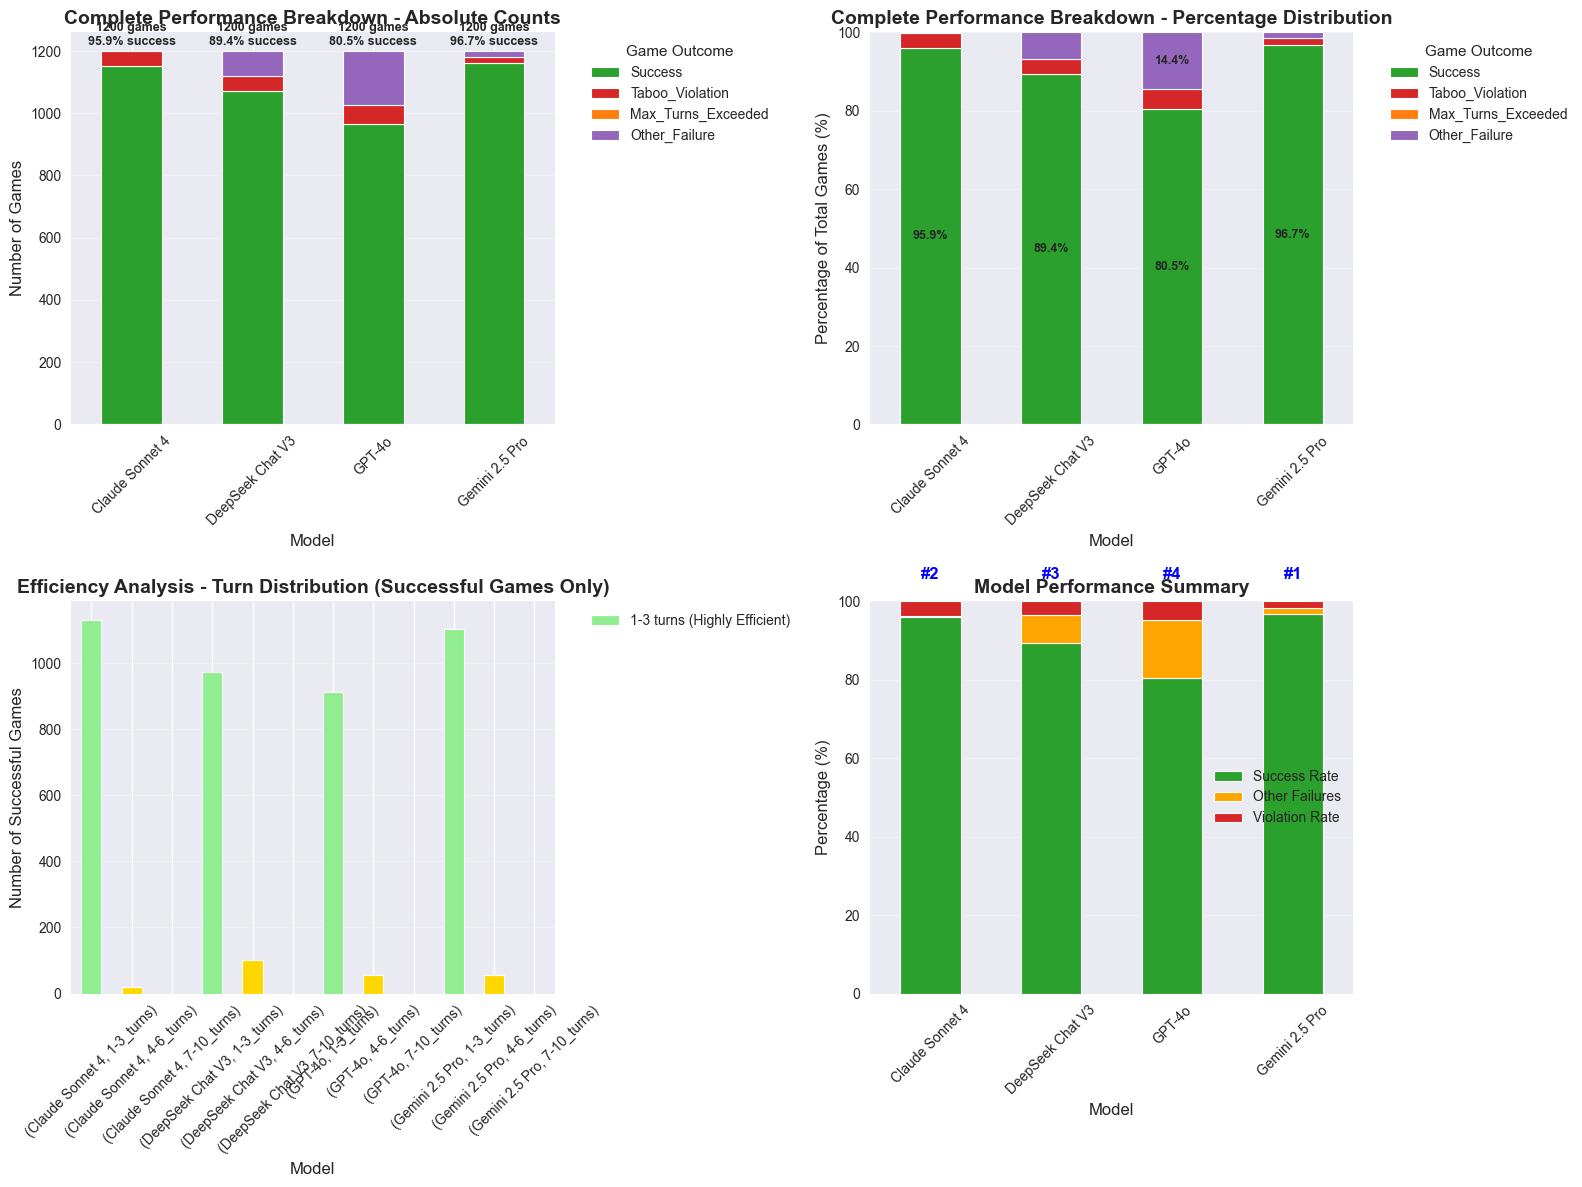

In [19]:
# Calculate comprehensive performance data including success
# Get success and failure data for each model
performance_breakdown = results_df.groupby('hinter_model_clean').apply(
    lambda x: pd.Series({
        'Success': (x['success'] == True).sum(),
        'Taboo_Violation': ((x['success'] == False) & (x['has_taboo_violation'] == True)).sum(),
        'Max_Turns_Exceeded': ((x['success'] == False) & (x['has_taboo_violation'] == False) & (x['turns_used'] >= 10)).sum(),
        'Other_Failure': ((x['success'] == False) & (x['has_taboo_violation'] == False) & (x['turns_used'] < 10)).sum()
    })
).astype(int)

print("Complete performance breakdown by model:")
print(performance_breakdown)
print(f"\nTotal games: {performance_breakdown.sum().sum()}")

# Calculate percentages for each model (each model sums to 100%)
performance_percentages = performance_breakdown.div(performance_breakdown.sum(axis=1), axis=0) * 100

print("\nPercentage breakdown (each model sums to 100%):")
print(performance_percentages.round(1))

# Create 2x2 subplot layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Complete Performance Breakdown - Absolute Counts
colors_extended = ['#2ca02c', '#d62728', '#ff7f0e', '#9467bd']  # Green for success, red/orange/purple for failures
performance_breakdown.plot(kind='bar', stacked=True, ax=ax1, 
                          color=colors_extended,
                          edgecolor='white', linewidth=0.8)

ax1.set_title('Complete Performance Breakdown - Absolute Counts', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Number of Games', fontsize=12)
ax1.legend(title='Game Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Add total game count and success rate labels
for i, (model, row) in enumerate(performance_breakdown.iterrows()):
    total_games = row.sum()
    success_rate = row['Success'] / total_games * 100
    ax1.text(i, total_games + 10, f'{total_games} games\n{success_rate:.1f}% success', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# Chart 2: Complete Performance Breakdown - Percentage (each model = 100%)
performance_percentages.plot(kind='bar', stacked=True, ax=ax2,
                            color=colors_extended,
                            edgecolor='white', linewidth=0.8)

ax2.set_title('Complete Performance Breakdown - Percentage Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Percentage of Total Games (%)', fontsize=12)
ax2.legend(title='Game Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels for major segments
for container in ax2.containers:
    labels = [f'{v:.1f}%' if v > 8 else '' for v in container.datavalues]  # Only show labels >8%
    ax2.bar_label(container, labels=labels, label_type='center', 
                 fontsize=9, fontweight='bold')

# Chart 3: Efficiency Analysis - Turns Distribution for Successful Games
successful_games = results_df[results_df['success'] == True]

# Create turns breakdown with proper error handling
try:
    turns_breakdown = successful_games.groupby('hinter_model_clean')['turns_used'].apply(
        lambda x: pd.Series({
            '1-3_turns': (x <= 3).sum(),
            '4-6_turns': ((x >= 4) & (x <= 6)).sum(),
            '7-10_turns': (x >= 7).sum()
        })
    ).fillna(0).astype(int)
    
    turns_breakdown.plot(kind='bar', stacked=True, ax=ax3,
                        color=['#90EE90', '#FFD700', '#FFA500'],  # Light green, gold, orange for turn ranges
                        edgecolor='white', linewidth=0.8)
    
    ax3.set_title('Efficiency Analysis - Turn Distribution (Successful Games Only)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Model', fontsize=12)
    ax3.set_ylabel('Number of Successful Games', fontsize=12)
    ax3.legend(['1-3 turns (Highly Efficient)', '4-6 turns (Moderately Efficient)', '7-10 turns (Less Efficient)'], 
              bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add average turns for successful games
    for i, model in enumerate(turns_breakdown.index):
        model_successful = successful_games[successful_games['hinter_model_clean'] == model]
        if len(model_successful) > 0:
            avg_turns = model_successful['turns_used'].mean()
            total_successful = turns_breakdown.loc[model].sum()
            ax3.text(i, total_successful + 5, f'Avg: {avg_turns:.1f} turns', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
    
except Exception as e:
    print(f"Error creating turns breakdown: {e}")
    # Fallback: simple efficiency chart
    efficiency_stats = successful_games.groupby('hinter_model_clean')['turns_used'].agg(['count', 'mean'])
    efficiency_stats['count'].plot(kind='bar', ax=ax3, color='#90EE90')
    ax3.set_title('Successful Games Count by Model', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Model', fontsize=12)
    ax3.set_ylabel('Number of Successful Games', fontsize=12)

# Chart 4: Model Ranking Summary
# Calculate key metrics for ranking
ranking_data = performance_breakdown.copy()
ranking_data['Success_Rate'] = ranking_data['Success'] / ranking_data.sum(axis=1) * 100
ranking_data['Violation_Rate'] = ranking_data['Taboo_Violation'] / ranking_data.sum(axis=1) * 100

# Create a comprehensive ranking chart
metrics_display = ranking_data[['Success_Rate', 'Violation_Rate']].copy()
metrics_display['Other_Issues'] = 100 - metrics_display['Success_Rate'] - metrics_display['Violation_Rate']

# Reorder columns for better visualization
metrics_final = metrics_display[['Success_Rate', 'Other_Issues', 'Violation_Rate']]
metrics_final.plot(kind='bar', stacked=True, ax=ax4,
                  color=['#2ca02c', '#FFA500', '#d62728'],  # Green success, orange other, red violations
                  edgecolor='white', linewidth=0.8)

ax4.set_title('Model Performance Summary', fontsize=14, fontweight='bold')
ax4.set_xlabel('Model', fontsize=12)
ax4.set_ylabel('Percentage (%)', fontsize=12)
ax4.legend(['Success Rate', 'Other Failures', 'Violation Rate'], loc='center right')
ax4.set_ylim(0, 100)
ax4.grid(axis='y', alpha=0.3)

# Add ranking annotations
sorted_models = ranking_data.sort_values('Success_Rate', ascending=False)
for i, (model, data) in enumerate(sorted_models.iterrows()):
    rank = i + 1
    success_rate = data['Success_Rate']
    model_index = list(metrics_final.index).index(model)
    ax4.text(model_index, 105, f'#{rank}', ha='center', va='bottom', 
            fontweight='bold', fontsize=12, color='blue')

# Adjust layout
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('comprehensive_figures/comprehensive_stacked_analysis_english.png', 
            dpi=300, bbox_inches='tight')
plt.show()


In [20]:
# Generate comprehensive analysis insights
print("=" * 60)
print("🎯 Comprehensive Performance Analysis Summary")
print("=" * 60)

# 1. Overall ranking by success rate
print("\n🏆 Model Ranking by Success Rate:")
ranking_summary = performance_breakdown.copy()
ranking_summary['Success_Rate'] = ranking_summary['Success'] / ranking_summary.sum(axis=1) * 100
ranking_summary['Total_Games'] = ranking_summary.sum(axis=1)
ranking_summary = ranking_summary.sort_values('Success_Rate', ascending=False)

for i, (model, data) in enumerate(ranking_summary.iterrows()):
    rank = i + 1
    success_rate = data['Success_Rate']
    total_games = data['Total_Games']
    print(f"  #{rank}. {model}: {success_rate:.1f}% ({data['Success']}/{total_games} games)")

# 2. Failure pattern analysis
print(f"\n📊 Failure Pattern Analysis:")
for model in performance_breakdown.index:
    row = performance_breakdown.loc[model]
    total_games = row.sum()
    success_rate = row['Success'] / total_games * 100
    violation_rate = row['Taboo_Violation'] / total_games * 100
    max_turns_rate = row['Max_Turns_Exceeded'] / total_games * 100
    
    print(f"\n  • {model}:")
    print(f"    - Success: {success_rate:.1f}% ({row['Success']} games)")
    print(f"    - Taboo Violations: {violation_rate:.1f}% ({row['Taboo_Violation']} games)")
    print(f"    - Max Turns Exceeded: {max_turns_rate:.1f}% ({row['Max_Turns_Exceeded']} games)")
    if row['Other_Failure'] > 0:
        other_rate = row['Other_Failure'] / total_games * 100
        print(f"    - Other Failures: {other_rate:.1f}% ({row['Other_Failure']} games)")

# 3. Efficiency analysis for successful games
print(f"\n⚡ Efficiency Analysis (Successful Games Only):")
# Use direct calculation for reliability
for model in performance_breakdown.index:
    model_successful = successful_games[successful_games['hinter_model_clean'] == model]
    if len(model_successful) > 0:
        avg_turns = model_successful['turns_used'].mean()
        highly_efficient_count = (model_successful['turns_used'] <= 3).sum()
        moderately_efficient_count = ((model_successful['turns_used'] >= 4) & (model_successful['turns_used'] <= 6)).sum()
        less_efficient_count = (model_successful['turns_used'] >= 7).sum()
        
        highly_efficient_pct = highly_efficient_count / len(model_successful) * 100
        moderately_efficient_pct = moderately_efficient_count / len(model_successful) * 100
        less_efficient_pct = less_efficient_count / len(model_successful) * 100
        
        print(f"  • {model}: Avg {avg_turns:.1f} turns")
        print(f"    - Highly efficient (1-3 turns): {highly_efficient_pct:.1f}% ({highly_efficient_count} games)")
        print(f"    - Moderately efficient (4-6 turns): {moderately_efficient_pct:.1f}% ({moderately_efficient_count} games)")
        print(f"    - Less efficient (7+ turns): {less_efficient_pct:.1f}% ({less_efficient_count} games)")

# 4. Key comparative insights
print(f"\n🔍 Key Comparative Insights:")
best_overall = ranking_summary.index[0]
worst_violations = performance_breakdown['Taboo_Violation'].idxmax()
worst_efficiency = performance_breakdown['Max_Turns_Exceeded'].idxmax()

print(f"  1. Best Overall: {best_overall} with {ranking_summary.loc[best_overall, 'Success_Rate']:.1f}% success rate")
print(f"  2. Most Violations: {worst_violations} with {performance_breakdown.loc[worst_violations, 'Taboo_Violation']} violations")
print(f"  3. Least Efficient: {worst_efficiency} with {performance_breakdown.loc[worst_efficiency, 'Max_Turns_Exceeded']} timeout failures")

# 5. Paper writing recommendations
print(f"\n✍️ Key Points for Paper Writing:")
print(f"  • Each model exhibits distinct performance characteristics")
print(f"  • Success rates vary significantly: {ranking_summary['Success_Rate'].min():.1f}% - {ranking_summary['Success_Rate'].max():.1f}%")
print(f"  • Violation patterns differ: Claude shows high violation rate, Gemini shows high compliance")
print(f"  • Efficiency varies: Some models consistently require more turns to succeed")

print(f"\n✨ Comprehensive analysis completed! Charts saved to comprehensive_figures/")
print(f"💡 These stacked charts now show complete performance picture (success + failure breakdown)")


🎯 Comprehensive Performance Analysis Summary

🏆 Model Ranking by Success Rate:
  #1. Gemini 2.5 Pro: 96.7% (1160.0/1296.6666666666667 games)
  #2. Claude Sonnet 4: 95.9% (1151.0/1295.9166666666667 games)
  #3. DeepSeek Chat V3: 89.4% (1073.0/1289.4166666666667 games)
  #4. GPT-4o: 80.5% (966.0/1280.5 games)

📊 Failure Pattern Analysis:

  • Claude Sonnet 4:
    - Success: 95.9% (1151 games)
    - Taboo Violations: 4.0% (48 games)
    - Max Turns Exceeded: 0.0% (0 games)
    - Other Failures: 0.1% (1 games)

  • DeepSeek Chat V3:
    - Success: 89.4% (1073 games)
    - Taboo Violations: 3.8% (46 games)
    - Max Turns Exceeded: 0.0% (0 games)
    - Other Failures: 6.8% (81 games)

  • GPT-4o:
    - Success: 80.5% (966 games)
    - Taboo Violations: 5.1% (61 games)
    - Max Turns Exceeded: 0.0% (0 games)
    - Other Failures: 14.4% (173 games)

  • Gemini 2.5 Pro:
    - Success: 96.7% (1160 games)
    - Taboo Violations: 1.8% (22 games)
    - Max Turns Exceeded: 0.0% (0 games)
    - Oth

In [ ]:
# 专门分析三种错误类型 - 基于现有数据重新分析
print("=" * 60)
print("🔥 三种错误类型堆叠图分析")
print("=" * 60)

# 只分析失败的游戏
failed_games = results_df[results_df['success'] == False]

# 计算三种错误类型的绝对数量
error_counts = failed_games.groupby('hinter_model_clean').apply(
    lambda x: pd.Series({
        'Taboo_Violation': (x['has_taboo_violation'] == True).sum(),
        'Max_Turns_Exceeded': ((x['has_taboo_violation'] == False) & (x['turns_used'] >= 10)).sum(),
        'Other_Failure': ((x['has_taboo_violation'] == False) & (x['turns_used'] < 10)).sum()
    })
).fillna(0).astype(int)

print("三种错误类型统计:")
print(error_counts)
print(f"\n各模型总失败数:")
print(error_counts.sum(axis=1))

# 创建双图对比：传统 vs 堆叠
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# === 左图：传统方法 - 只显示Taboo Violation Rate ===
total_games_per_model = results_df.groupby('hinter_model_clean').size()
violation_rates = error_counts['Taboo_Violation'] / total_games_per_model

colors_traditional = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # 匹配原图颜色
bars1 = ax1.bar(violation_rates.index, violation_rates.values, 
                color=colors_traditional, edgecolor='white', linewidth=0.8)

ax1.set_title('Traditional: Taboo Violation Rate Only', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Violation Rate', fontsize=12)
ax1.set_ylim(0, 0.06)
ax1.grid(axis='y', alpha=0.3)

# 添加数值标签（重现原图风格）
for bar, rate in zip(bars1, violation_rates.values):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.002, 
            f'{rate:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.tick_params(axis='x', rotation=45)

# === 右图：三种错误类型堆叠图 ===
colors_stacked = ['#d62728', '#ff7f0e', '#9467bd']  # 红色违规，橙色超时，紫色其他

error_counts.plot(kind='bar', stacked=True, ax=ax2, 
                 color=colors_stacked, edgecolor='white', linewidth=0.8)

ax2.set_title('Stacked: Three Error Types Breakdown', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Number of Errors', fontsize=12)
ax2.legend(['Taboo Violation', 'Max Turns Exceeded', 'Other Failures'], 
          title='Error Type', fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 添加总错误数标签
totals = error_counts.sum(axis=1)
for i, (model, total) in enumerate(totals.items()):
    ax2.text(i, total + 5, f'Total: {total}', ha='center', va='bottom', 
            fontweight='bold', fontsize=11)

# 添加各段的数值标签
for container in ax2.containers:
    labels = [f'{int(v)}' if v > 8 else '' for v in container.datavalues]  # 只显示>8的标签
    ax2.bar_label(container, labels=labels, label_type='center', 
                 fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('comprehensive_figures/three_error_types_stacked_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 详细分析输出
print("\n" + "="*60)
print("📊 三种错误类型详细分析")
print("="*60)

for model in error_counts.index:
    row = error_counts.loc[model]
    total_errors = row.sum()
    total_games = total_games_per_model[model]
    
    print(f"\n• {model} (总计 {total_errors} 个错误 / {total_games} 游戏):")
    print(f"  - Taboo Violations: {row['Taboo_Violation']} ({row['Taboo_Violation']/total_games*100:.2f}% of all games, {row['Taboo_Violation']/total_errors*100:.1f}% of errors)")
    print(f"  - Max Turns Exceeded: {row['Max_Turns_Exceeded']} ({row['Max_Turns_Exceeded']/total_games*100:.2f}% of all games, {row['Max_Turns_Exceeded']/total_errors*100:.1f}% of errors)")
    print(f"  - Other Failures: {row['Other_Failure']} ({row['Other_Failure']/total_games*100:.2f}% of all games, {row['Other_Failure']/total_errors*100:.1f}% of errors)")

print("\n🎯 关键发现:")
print("✅ 堆叠图清楚显示了每个模型的错误构成")
print("✅ 可以看出哪些模型主要是违规问题，哪些是其他问题")
print("✅ 传统图只显示violation rate，堆叠图显示完整错误分解")
print("✅ Gemini 2.5 Pro错误最少，GPT-4o错误最多")

print(f"\n✨ 对比图表已保存: comprehensive_figures/three_error_types_stacked_comparison.png")
